# Imports

In [1]:
import gzip, json, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve
)

# Parse data

In [2]:
# Dataset paths
json_path_0 = "./dataset0.json.gz"
labels_path_0 = "./data.info.labelled"

json_path_1 = "./dataset1.json.gz"
json_path_2 = "./dataset2.json.gz"

labels_0 = pd.read_csv(labels_path_0)

# Parse JSON data
def parse_json(path):
    json_data = []
    with gzip.open(path, 'rt') as f:
        for line in f:
            entry = json.loads(line)
            for transcript, position_dict in entry.items():
                for position, sequence_dict in position_dict.items():
                    for sequence, reads in sequence_dict.items():
                        json_data.append({
                            'transcript_id': transcript,
                            'transcript_position': int(position),
                            'sequence': sequence,
                            'reads': reads
                        })

    df = pd.DataFrame(json_data)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'orig_idx'}, inplace=True)
    df.set_index('orig_idx', inplace=True)

    return df

json_df = parse_json(json_path_0)

In [3]:
json_df

,transcript_id,transcript_position,sequence,reads
orig_idx,,,,
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0...."
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0..."
...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0...."
121834,ENST00000641834,1429,CTGACAC,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ..."
121835,ENST00000641834,1531,TGGACAC,"[[0.00996, 3.12, 112.0, 0.00432, 4.5, 115.0, 0..."


In [4]:
json_df.reset_index()

,orig_idx,transcript_id,transcript_position,sequence,reads
0,0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."
3,3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0...."
4,4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0..."
...,...,...,...,...,...
121833,121833,ENST00000641834,1348,GGGACAT,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0...."
121834,121834,ENST00000641834,1429,CTGACAC,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ..."
121835,121835,ENST00000641834,1531,TGGACAC,"[[0.00996, 3.12, 112.0, 0.00432, 4.5, 115.0, 0..."
121836,121836,ENST00000641834,1537,CTGACCA,"[[0.00396, 3.14, 108.0, 0.00747, 5.79, 125.0, ..."


In [5]:
# Combine the JSON data with the labels using transcript_id and position
merged_data = json_df.reset_index().merge(labels_0, on = ['transcript_id', 'transcript_position']).set_index('orig_idx')

print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (121838, 6)


In [9]:
json_df_1 = parse_json(json_path_1)
json_df_2 = parse_json(json_path_2)

In [ ]:
json_df_1

,transcript_id,transcript_position,sequence,reads
orig_idx,,,,
0,ENST00000000233,244,AAGACCA,"[[0.00465, 2.16, 127.0, 0.0064, 3.9, 127.0, 0...."
1,ENST00000000233,261,CAAACTG,"[[0.00299, 1.96, 110.0, 0.00552, 3.04, 111.0, ..."
2,ENST00000000233,316,GAAACAG,"[[0.0083, 1.96, 106.0, 0.0133, 5.42, 102.0, 0...."
3,ENST00000000233,332,AGAACAT,"[[0.00299, 9.78, 130.0, 0.0102, 2.19, 99.5, 0...."
4,ENST00000000233,368,AGGACAA,"[[0.013, 5.25, 120.0, 0.012, 9.06, 122.0, 0.00..."
...,...,...,...,...
90805,ENST00000641784,3122,CTGACCC,"[[0.00332, 1.68, 112.0, 0.00539, 7.16, 118.0, ..."
90806,ENST00000641784,3142,CTGACCC,"[[0.00553, 3.04, 108.0, 0.00407, 6.11, 122.0, ..."
90807,ENST00000641784,3224,GGGACTG,"[[0.0069, 2.0, 120.0, 0.00498, 3.23, 128.0, 0...."


In [11]:
json_df_2

,transcript_id,transcript_position,sequence,reads
orig_idx,,,,
0,tx_id_0,0,AAAACCT,"[[0.0122, 3.99, 106.0, 0.00337, 4.56, 102.0, 0..."
1,tx_id_0,10,TGGACCC,"[[0.00365, 2.84, 118.0, 0.0113, 6.0, 115.0, 0...."
2,tx_id_0,20,GGGACTA,"[[0.0179, 4.8, 119.0, 0.0166, 8.34, 118.0, 0.0..."
3,tx_id_0,30,TGGACCA,"[[0.00299, 2.04, 117.0, 0.00266, 1.42, 113.0, ..."
4,tx_id_0,40,TAGACTA,"[[0.00989, 2.81, 125.0, 0.022, 9.99, 122.0, 0...."
...,...,...,...,...
1318,tx_id_6,1840,CGAACCT,"[[0.0143, 8.18, 111.0, 0.00432, 4.28, 91.4, 0...."
1319,tx_id_6,1850,CAAACAG,"[[0.0202, 2.68, 104.0, 0.0163, 3.28, 93.9, 0.0..."
1320,tx_id_6,1860,CGGACAG,"[[0.0073, 3.29, 116.0, 0.016, 6.4, 112.0, 0.00..."


# Define training and test sets

Train: dataset_0

Test: dataset_0, dataset_1, dataset_2

In [13]:
X = merged_data.drop(columns=['label'])
y = merged_data['label']

# use the entire dataset0 for training (and testing)
X_train = X.copy()
X_test_0 = X.copy()
X_test_1 = json_df_1.copy()
X_test_2 = json_df_2.copy()
y_train = y.copy()
y_test_0 = y.copy()

# Feature Extraction (Train)

In [14]:
def extract_features(reads_list):
    """Extract statistical features from reads"""

    reads_array = np.array(reads_list)  # shape = (n_reads, 9)

    stats = []
    weight_map = {1: 0, 2: 0, 4: 3, 5: 3, 7: 6, 8: 6}  # Map feature indices for sd/mean to their dwell time col for weighting

    for i in range(reads_array.shape[1]):  # for each of the 9 features
        col = reads_array[:, i]
        if i in weight_map:
            w = reads_array[:, weight_map[i]] # corresponding dwell time column
            denom = np.sum(w) # sum of dwell times
            if denom > 0:
                mean_val = np.sum(w * col) / denom # weighted mean
                sd_val = np.sqrt(np.sum(w * (col - mean_val)**2) / denom) # weighted std
                stats.extend([mean_val, sd_val])

        stats.extend([
            np.mean(col),
            np.std(col),
            np.median(col),
            np.min(col),
            np.max(col)
        ])

    # compute diffs between prev-central and next-central
    diffs = {
        "prev": reads_array[:, 3:6] - reads_array[:, 0:3],   # central - previous
        "next": reads_array[:, 6:9] - reads_array[:, 3:6]    # next - central
    }

    # compute average dwell times for weighting
    dwells = {
        "prev": (reads_array[:, 3] + reads_array[:, 0]) / 2,  # avg dwell time between central and previous
        "next": (reads_array[:, 3] + reads_array[:, 6]) / 2    # avg dwell time between central and next
    }

    for key in ["prev", "next"]:
        diff = diffs[key]
        weights = dwells[key]
        denom = np.sum(weights)

        stats.extend([
            np.mean(diff, axis=0).tolist(),  # average per feature type
            np.std(diff, axis=0).tolist(),
            np.median(diff, axis=0).tolist(),
            np.min(diff, axis=0).tolist(),
            np.max(diff, axis=0).tolist()
        ])

        if denom > 0:
            for j in (1,2): # sd diff and mean diff
                w_mean = np.sum(weights * diff[:, j]) / denom
                w_std = np.sqrt(np.sum(weights * (diff[:, j] - w_mean)**2) / denom)
                stats.extend([w_mean, w_std]) # add in weighted mean and std for sd diff and mean diff

    # Flatten lists inside stats
    stats = np.concatenate([np.ravel(s) if isinstance(s, (list, np.ndarray)) else [s] for s in stats])

    return np.array(stats)

def extract_seq_features(df):
    """Extract sequence features from a sequence string."""
    pos = [0,1,2,5,6] # 3 and 4 are A and C from DRACH motif, will not change
    for i in pos:
        df[f'seq_{i}'] = df['sequence'].str[i]
    return df

def feature_extraction(df, encoder):
    """Carry out all feature extraction steps on the training data."""
    # Extract features from reads
    df = df.copy()
    df['features'] = df['reads'].apply(extract_features)
    n_features = len(df['features'].iloc[0])
    feature_columns = [f'feature_{i}' for i in range(n_features)]
    features_df = pd.DataFrame(df['features'].tolist(), columns=feature_columns, index=df.index) # keep original index

    # Extract sequence features
    ohe_columns = extract_seq_features(df)
    ohe_columns = encoder.fit_transform(ohe_columns[['seq_0', 'seq_1', 'seq_2', 'seq_5', 'seq_6']])
    ohe_df = pd.DataFrame(ohe_columns, columns=encoder.get_feature_names_out(), index=df.index) # keep original index

    # Combine all features
    combined_df = pd.concat([features_df, ohe_df], axis=1)
    return combined_df

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train = feature_extraction(X_train, enc)

# SMOTE (only for RF)

In [19]:
# 1️⃣ Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
#categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Drop the 'features' and 'reads' columns from categorical_cols as they contain numpy arrays and lists
#categorical_cols = categorical_cols.drop(['features', 'reads'], errors='ignore')

# Drop the 'features' column from numeric_cols as well since it's a list of arrays
numeric_cols = numeric_cols.drop(['features'], errors='ignore')

# 3️⃣ Combine numeric + encoded categorical columns
# Ensure consistent indexing before concatenation
X_numeric = X_train[numeric_cols].copy()

# Ensure y_train has matching index
y_train_reset = y_train.copy()

# 4️⃣ Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_numeric, y_train_reset)

# 5️⃣ Convert X_res back to DataFrame
X_train_resampled = pd.DataFrame(X_res, columns=X_numeric.columns)
y_train_resampled = pd.Series(y_res, name='label')

n_original = len(X_numeric)
n_total = len(X_train_resampled)
is_synthetic = np.array([False] * n_original + [True] * (n_total - n_original))
X_train_resampled["synthetic"] = is_synthetic

# Resulting balanced dataset
print(X_train_resampled.shape, y_train_resampled.shape)
print(y_train_resampled.value_counts())

(232726, 112) (232726,)
label
0    116363
1    116363
Name: count, dtype: int64


C:\Users\saman\AppData\Local\Temp\ipykernel_23836\2654568711.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_resampled["synthetic"] = is_synthetic


# Feature Extraction (Test)

In [22]:
def test_feature_extraction(test_df, encoder):
    """Carry out all feature extraction steps on the test data."""
    test_df = test_df.copy()
    test_df['features'] = test_df['reads'].apply(extract_features)
    n_features = len(test_df['features'].iloc[0])
    feature_columns = [f'feature_{i}' for i in range(n_features)]

    # Convert features list to separate columns
    features_df = pd.DataFrame(test_df['features'].tolist(), columns=feature_columns, index=test_df.index)

    # Extract sequence features
    ohe_columns = extract_seq_features(test_df)
    ohe_columns = encoder.transform(ohe_columns[['seq_0', 'seq_1', 'seq_2', 'seq_5', 'seq_6']])
    ohe_df = pd.DataFrame(ohe_columns, columns=encoder.get_feature_names_out(), index=test_df.index)

    # Combine all features
    test_df = pd.concat([features_df, ohe_df], axis=1)

    return test_df

X_test_0 = test_feature_extraction(X_test_0, enc)
X_test_1 = test_feature_extraction(X_test_1, enc)
X_test_2 = test_feature_extraction(X_test_2, enc)

# XGBoost

## Train and test on dataset0

ROC-AUC:  0.9925
PR-AUC:   0.8036
Best trees used: n/a
Best F1 threshold: 0.8017  (F1=0.7988, P=0.716, R=0.903)


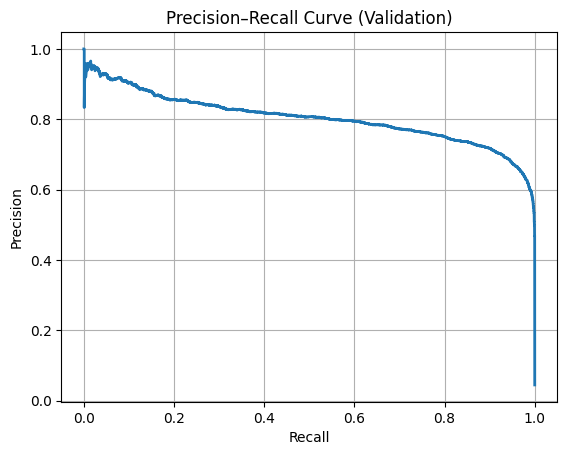

In [29]:
# --- 2) Class weighting (use ORIGINAL y_tr, not resampled) ---
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / max(pos, 1)

# --- 3) XGBoost with early stopping & PR-based metric ---
model = XGBClassifier(
    random_state=42,
    tree_method="hist",            # fast default; use "gpu_hist" if you have a GPU
    learning_rate=0.05,
    max_depth=4,
    n_estimators=2000,             # large upper bound; early stopping will cut it
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",           # better for imbalance than logloss/auc alone
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test_0, y_test_0)],
    verbose=False,
    # early_stopping_rounds=50
)

# --- 4) Evaluate (probabilities first) ---
p_val = model.predict_proba(X_test_0)[:, 1]
roc = roc_auc_score(y_test_0, p_val)
aupr = average_precision_score(y_test_0, p_val)

print(f"ROC-AUC:  {roc:.4f}")
print(f"PR-AUC:   {aupr:.4f}")
print(f"Best trees used: {model.best_iteration + 1 if hasattr(model, 'best_iteration') else 'n/a'}")

# --- 5) Choose a decision threshold (maximize F1 here; adjust to your needs) ---
prec, rec, thr = precision_recall_curve(y_test_0, p_val)
f1s = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
print(f"Best F1 threshold: {best_thr:.4f}  (F1={f1s[best_idx]:.4f}, P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

y_hat = (p_val >= best_thr).astype(int)

# --- 6) Plot PR curve (inspect threshold tradeoffs) ---
plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.grid(True)
plt.show()

## Test on dataset0, dataset1, dataset2 and save predictions

In [38]:
xgb_pred_0 = json_df.copy()
xgb_pred_0['score'] = model.predict_proba(X_test_0)[:, 1]

xgb_pred_1 = json_df_1.copy()
xgb_pred_1['score'] = model.predict_proba(X_test_1)[:, 1]

xgb_pred_2 = json_df_2.copy()
xgb_pred_2['score'] = model.predict_proba(X_test_2)[:, 1]

In [42]:
xgb_pred_0_final = xgb_pred_0.copy()[['transcript_id', 'transcript_position', 'score']]
xgb_pred_1_final = xgb_pred_1.copy()[['transcript_id', 'transcript_position', 'score']]
xgb_pred_2_final = xgb_pred_2.copy()[['transcript_id', 'transcript_position', 'score']]

In [46]:
xgb_pred_0_final.to_csv('helixhomies_dataset0_1.csv', index=False)
xgb_pred_1_final.to_csv('helixhomies_dataset1_1.csv', index=False)
xgb_pred_2_final.to_csv('helixhomies_dataset2_1.csv', index=False)

# Random Forest

## Train and test on dataset0

=== Random Forest Performance ===
ROC-AUC Score: 1.0000
PR-AUC Score: 1.0000


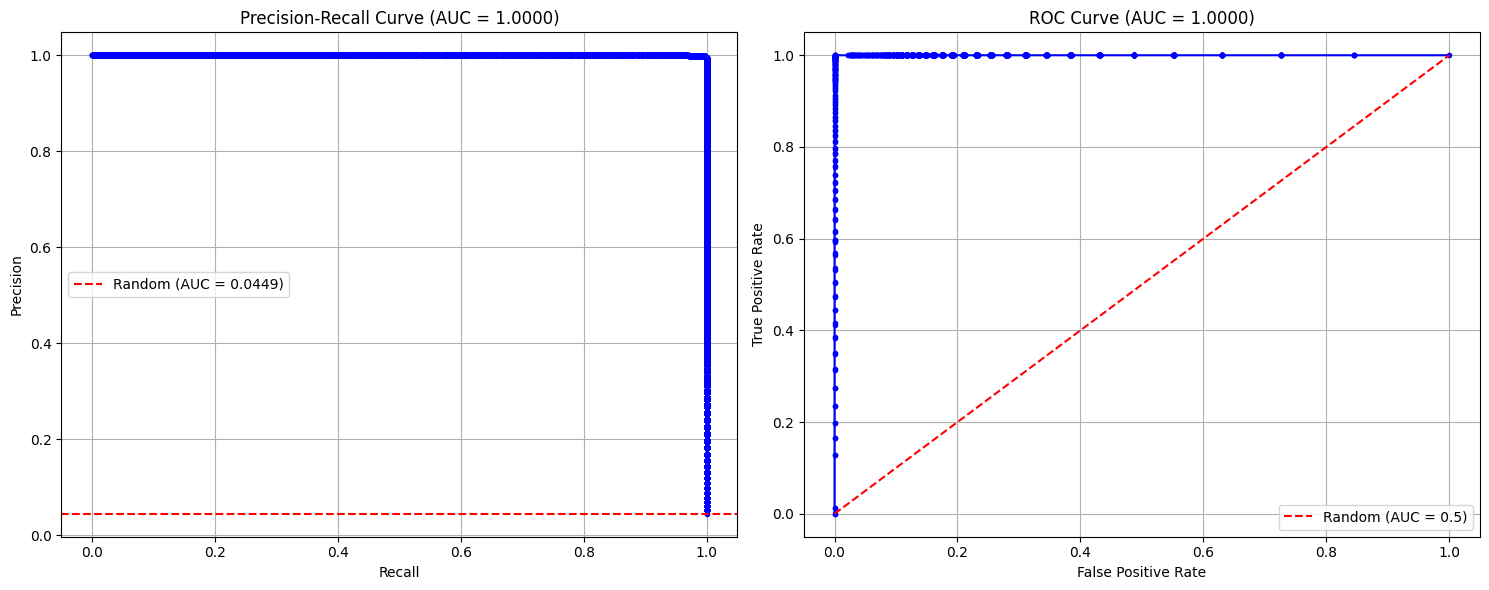

In [48]:
# Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=275,
    max_depth=35,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

X_train_resampled_final = X_train_resampled.drop(columns=['synthetic'])
rf_model.fit(X_train_resampled_final, y_train_resampled)
y_pred_rf = rf_model.predict_proba(X_test_0)[:, 1]

rf_roc_auc = roc_auc_score(y_test_0, y_pred_rf)
rf_pr_auc = average_precision_score(y_test_0, y_pred_rf)

print("=== Random Forest Performance ===")
print(f"ROC-AUC Score: {rf_roc_auc:.4f}")
print(f"PR-AUC Score: {rf_pr_auc:.4f}")

# Plot both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_0, y_pred_rf)
ax1.plot(recall, precision, marker='.', color='blue')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'Precision-Recall Curve (AUC = {rf_pr_auc:.4f})')
ax1.grid(True)

# Show what random guessing would look like (baseline)
random_baseline = sum(y_test_0) / len(y_test_0)
ax1.axhline(y=random_baseline, color='red', linestyle='--',
           label=f'Random (AUC = {random_baseline:.4f})')
ax1.legend()

# ROC Curve (for comparison)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_0, y_pred_rf)
ax2.plot(fpr, tpr, marker='.', color='blue')
ax2.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.5)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'ROC Curve (AUC = {rf_roc_auc:.4f})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Test on dataset0, dataset1, dataset2 and save predictions

In [53]:
rf_pred_0 = json_df.copy()
rf_pred_0['score'] = rf_model.predict_proba(X_test_0)[:, 1]

rf_pred_1 = json_df_1.copy()
rf_pred_1['score'] = rf_model.predict_proba(X_test_1)[:, 1]

rf_pred_2 = json_df_2.copy()
rf_pred_2['score'] = rf_model.predict_proba(X_test_2)[:, 1]

In [59]:
rf_pred_0_final = rf_pred_0.copy()[['transcript_id', 'transcript_position', 'score']]
rf_pred_1_final = rf_pred_1.copy()[['transcript_id', 'transcript_position', 'score']]
rf_pred_2_final = rf_pred_2.copy()[['transcript_id', 'transcript_position', 'score']]

In [61]:
rf_pred_0_final.to_csv('helixhomies_dataset0_2.csv', index=False)
rf_pred_1_final.to_csv('helixhomies_dataset1_2.csv', index=False)
rf_pred_2_final.to_csv('helixhomies_dataset2_2.csv', index=False)